
# 🧠 Brain Tumor MRI Image Classification — Colab Notebook
End-to-end workflow following your 8-step plan: dataset understanding → preprocessing → augmentation → models (Custom CNN + Transfer Learning: EfficientNetB0 & ResNet50) → training → evaluation → comparison → export.

> **How to use (Colab):** Open this notebook in Google Colab → Run the **Setup** cells → Point `DATA_DIR` to your dataset (Drive or zipped) → Execute cells top-to-bottom.


## 0. Environment & Drive Setup

In [1]:

# If running on Colab, uncomment to mount Google Drive
from pathlib import Path

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# ✅ Configure your dataset root here.
# Expecting directory format:
# DATA_DIR/
#   train/<class_name>/*
#   val/<class_name>/*
#   test/<class_name>/*   # optional
DATA_DIR = "/content/drive/MyDrive/Tumour"   # Change to your path or Drive path, e.g., "/content/drive/MyDrive/tumor_dataset/data"

Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# Optional: unzip a dataset stored on Drive
# !unzip -q "/content/drive/MyDrive/tumor_dataset.zip" -d /content/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 🔧 Colab Environment Fix — TensorFlow 2.19.x (Recommended)
# Ensures compatibility with preinstalled packages and avoids version conflicts

!pip uninstall -y tensorflow tensorflow-text tf-keras tensorflow-decision-forests tensorflow-gpu tensorflow-intel -q
!pip install -q tensorflow==2.19.0 tensorflow-text==2.19.0 tf-keras==2.19.0
print("✅ TensorFlow 2.19.x environment ready. Please RESTART the runtime before continuing.")



✅ TensorFlow 2.19.x environment ready. Please RESTART the runtime before continuing.


## 1. Imports & Global Config

In [13]:

import os, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

print("TF version:", tf.__version__)

SEED = 1337
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)


TF version: 2.19.0



## 2. Understand the Dataset
- Count categories and images per split
- Peek at a few sample images
- Check for class imbalance and resolutions


,split,label,path
0,train,glioma,/content/drive/MyDrive/Tumour/train/glioma/Tr-...
1,train,glioma,/content/drive/MyDrive/Tumour/train/glioma/Tr-...
2,train,glioma,/content/drive/MyDrive/Tumour/train/glioma/Tr-...
3,train,glioma,/content/drive/MyDrive/Tumour/train/glioma/Tr-...
4,train,glioma,/content/drive/MyDrive/Tumour/train/glioma/Tr-...


Counts by split:


,count
split,
test,246
train,1695
val,502


Counts by split & label:


split,test,train,val
label,,,
glioma,80,564,161
meningioma,63,358,124
no_tumor,49,335,99
pituitary,54,438,118


Sampled resolution stats (W,H):


,width,height
count,50.0,50.0
mean,640.0,640.0
std,0.0,0.0
min,640.0,640.0
25%,640.0,640.0
50%,640.0,640.0
75%,640.0,640.0
max,640.0,640.0


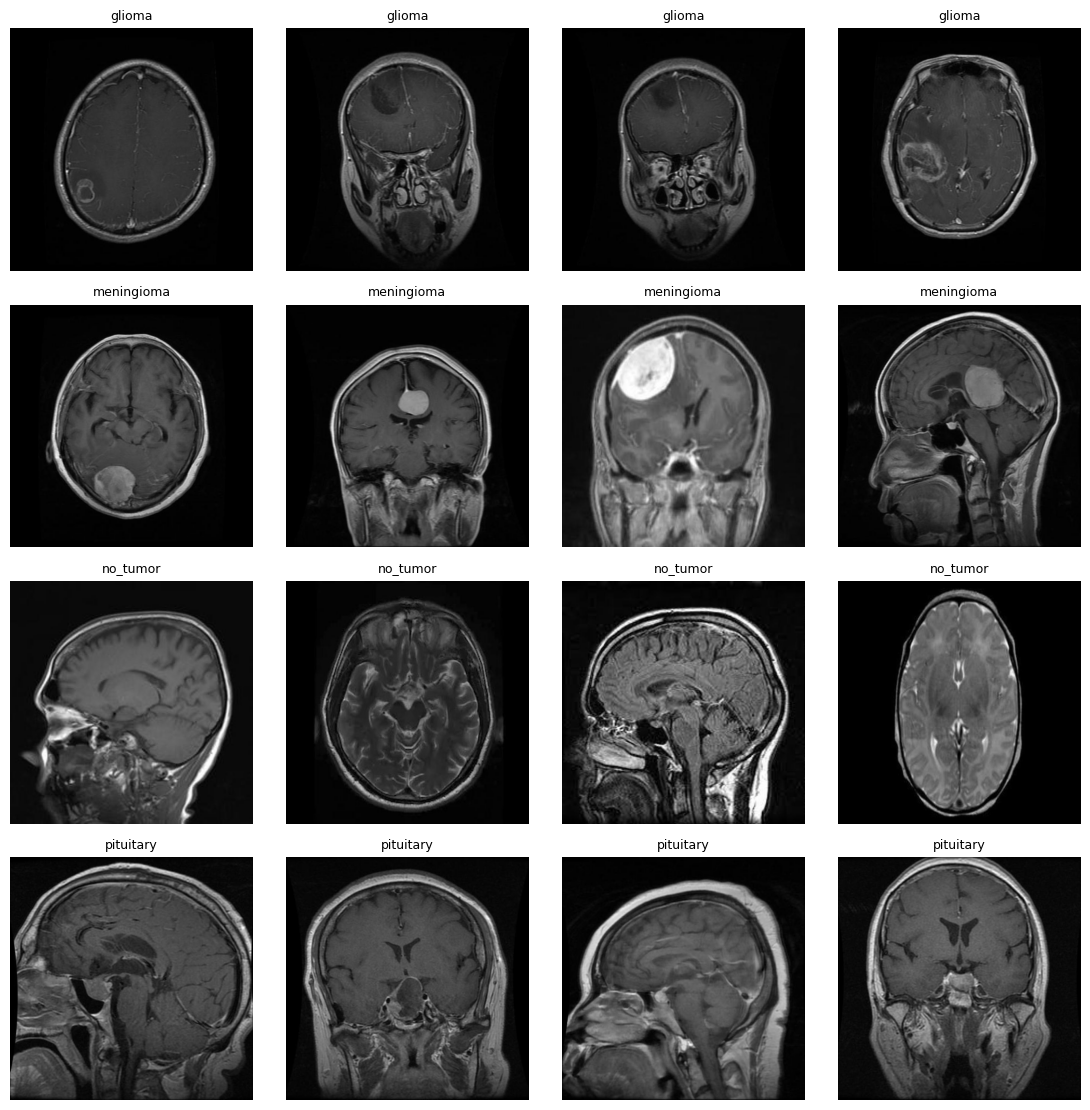

In [14]:

from collections import Counter
from pathlib import Path
from PIL import Image

def list_images(root):
    root = Path(root)
    items = []
    if not root.exists():
        return pd.DataFrame(items, columns=["split","label","path"])
    for split in ["train", "val", "test"]:
        d = root / split
        if not d.exists():
            continue
        for cls in sorted([p.name for p in d.iterdir() if p.is_dir()]):
            for imgp in (d/cls).glob("*"):
                if imgp.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]:
                    items.append([split, cls, str(imgp)])
    return pd.DataFrame(items, columns=["split","label","path"])

df = list_images(DATA_DIR)
if df.empty:
    print("⚠️ No images found. Ensure DATA_DIR has train/val[/test] with class folders.")
else:
    display(df.head())
    print("Counts by split:")
    display(df.groupby("split").size().to_frame("count"))
    print("Counts by split & label:")
    display(df.groupby(["split","label"]).size().to_frame("count").reset_index().pivot(index="label", columns="split", values="count").fillna(0))

    # Resolution sampling
    sample_paths = df.sample(min(50, len(df)), random_state=SEED)["path"].tolist()
    sizes = []
    for p in sample_paths:
        try:
            with Image.open(p) as im:
                sizes.append(im.size)  # (W, H)
        except Exception:
            pass
    if sizes:
        wh = pd.DataFrame(sizes, columns=["width","height"])
        print("Sampled resolution stats (W,H):")
        display(wh.describe())

    # Show a grid of sample images per class (train split)
    def show_samples_per_class(n_per_class=4):
        dtrain = df[df["split"]=="train"]
        labels = sorted(dtrain["label"].unique())
        nrows = len(labels); ncols = n_per_class
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.8, nrows*2.8))
        if nrows == 1: axes = np.array([axes])
        for r, lbl in enumerate(labels):
            imgs = dtrain[dtrain["label"]==lbl]["path"].sample(min(n_per_class, sum(dtrain['label']==lbl)), random_state=SEED)
            for c, pth in enumerate(imgs):
                ax = axes[r, c] if ncols>1 else axes[r, 0]
                try:
                    ax.imshow(Image.open(pth))
                    ax.set_title(lbl, fontsize=9)
                    ax.axis("off")
                except Exception:
                    ax.axis("off")
        plt.tight_layout(); plt.show()

    if (df["split"]=="train").any():
        show_samples_per_class(4)



## 3. Data Preprocessing & Augmentation
- Normalize pixels to [0,1]
- Resize to 224×224
- Augment with flips, rotations, zooms, translations, contrast


In [15]:

def make_datasets(data_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        label_mode="categorical",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = train_ds.class_names

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    # Augmentations
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ])

    train_ds = (train_ds
                .map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
                .map(norm, num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))

    def make_eval(split):
        p = os.path.join(data_dir, split)
        if os.path.exists(p):
            ds = tf.keras.preprocessing.image_dataset_from_directory(
                p, label_mode="categorical", seed=seed, image_size=img_size, batch_size=batch_size
            )
            return ds.map(norm, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        return None

    val_ds  = make_eval("val")
    test_ds = make_eval("test")
    return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, CLASS_NAMES = make_datasets(DATA_DIR)
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)


Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']



## 4. Model Building — Custom CNN
- Conv → BN → MaxPool blocks
- Dropout to reduce overfitting


In [6]:

def build_custom_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(256, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

custom_cnn = build_custom_cnn()
custom_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,364 (1.49 MB)

 Trainable params: 390,404 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)


## 5. Transfer Learning — EfficientNetB0 & ResNet50
- ImageNet weights
- Replace top with GAP → Dropout → Dense
- Optional fine-tuning (unfreeze top layers)


In [16]:

def build_tl_model(backbone="efficientnetb0", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES, train_base=False):
    bb = backbone.lower()
    if bb == "efficientnetb0":
        Base = tf.keras.applications.EfficientNetB0
        preprocess = tf.keras.applications.efficientnet.preprocess_input
    elif bb == "resnet50":
        Base = tf.keras.applications.ResNet50
        preprocess = tf.keras.applications.resnet50.preprocess_input
    else:
        raise ValueError("Unsupported backbone: choose 'efficientnetb0' or 'resnet50'")

    base = Base(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = train_base  # False for feature extraction

    inputs = layers.Input(shape=input_shape)
    x = preprocess(inputs)
    x = base(x, training=False if not train_base else None)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(1e-3 if not train_base else 1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

effnet = build_tl_model("efficientnetb0", train_base=False)
resnet = build_tl_model("resnet50", train_base=False)

print("EfficientNetB0:"); effnet.summary()
print("ResNet50:"); resnet.summary()


EfficientNetB0:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

ResNet50:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ input_layer_14[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ input_layer_14[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ input_layer_14[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │      8,196 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


## 6. Model Training
- Train Custom CNN and TL models with callbacks
- Save best weights


In [20]:
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import callbacks
import os

# Save directory setup
SAVE_DIR = "/content/models" if IN_COLAB else "./models"
os.makedirs(SAVE_DIR, exist_ok=True)

def train_model(model, name, train_ds, val_ds, epochs=25):
    # 🔹 Modern Keras format with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    ckpt_path = os.path.join(SAVE_DIR, f"best_{name}_{timestamp}.keras")

    # 🔹 Training callbacks
    cbs = [
        callbacks.ModelCheckpoint(
            filepath=ckpt_path,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            verbose=1,
            save_weights_only=False,
        ),
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            mode="max",
            patience=6,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            mode="max",
            patience=3,
            factor=0.5,
            verbose=1
        )
    ]

    print(f"🔹 Training {name.upper()} for {epochs} epochs...")
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs)

    print(f"✅ Training completed. Best model saved at: {ckpt_path}")
    return hist, ckpt_path

# 🔹 Train all models (with 15 epochs each)
hist_custom, path_custom = train_model(custom_cnn, "custom_cnn", train_ds, val_ds, epochs=15)
hist_eff,    path_eff    = train_model(effnet, "efficientnetb0", train_ds, val_ds, epochs=15)
hist_res,    path_res    = train_model(resnet, "resnet50", train_ds, val_ds, epochs=15)

print("✅ Saved model paths:")
print(path_custom)
print(path_eff)
print(path_res)


🔹 Training CUSTOM_CNN for 15 epochs...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8457 - loss: 0.4167
Epoch 1: val_accuracy improved from -inf to 0.70120, saving model to /content/models/best_custom_cnn_20251111_152616.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.8460 - loss: 0.4161 - val_accuracy: 0.7012 - val_loss: 0.9103 - learning_rate: 1.2500e-04
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8087 - loss: 0.4544
Epoch 2: val_accuracy did not improve from 0.70120
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 588ms/step - accuracy: 0.8093 - loss: 0.4533 - val_accuracy: 0.6972 - val_loss: 0.9885 - learning_rate: 1.2500e-04
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8338 - loss: 0.4174
Epoch 3: val_accuracy improved from 0.70120 to 0.72510, saving model to /content/models/best_custom_cnn_20251111_152616.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 589ms/step - accuracy: 0.8342 - loss: 0.4168 - val_accuracy: 0.7251 - val_loss: 

### Training Curves

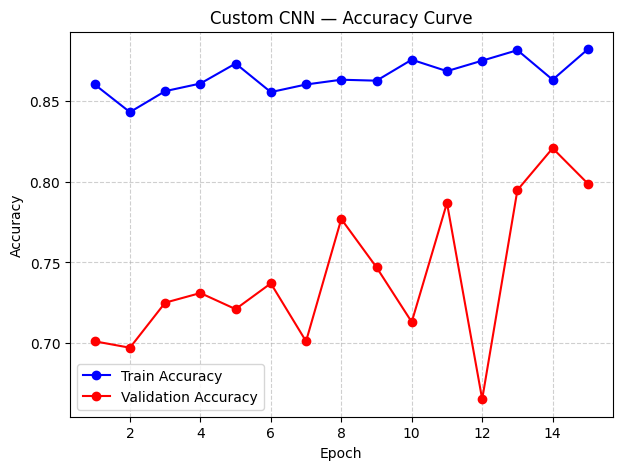

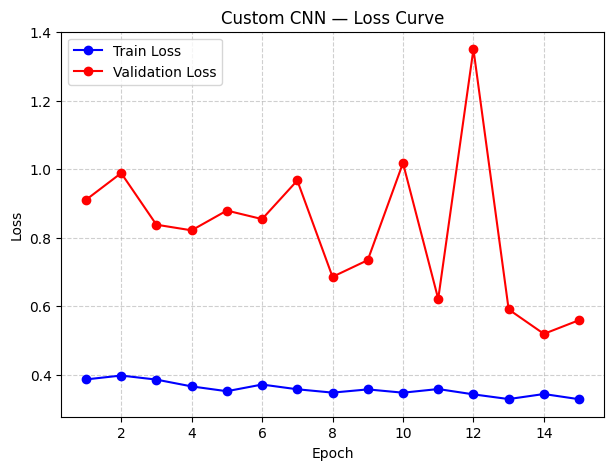

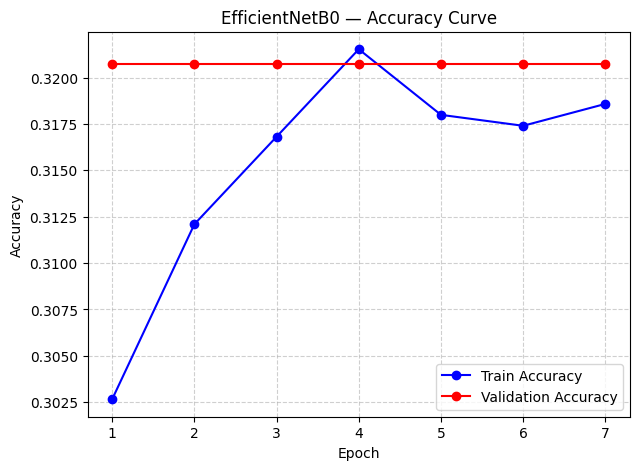

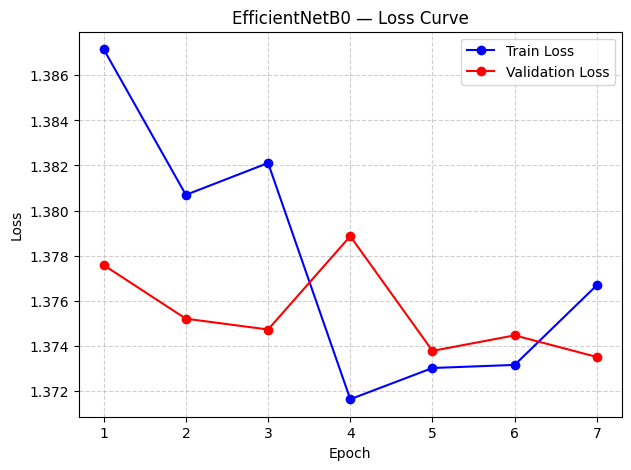

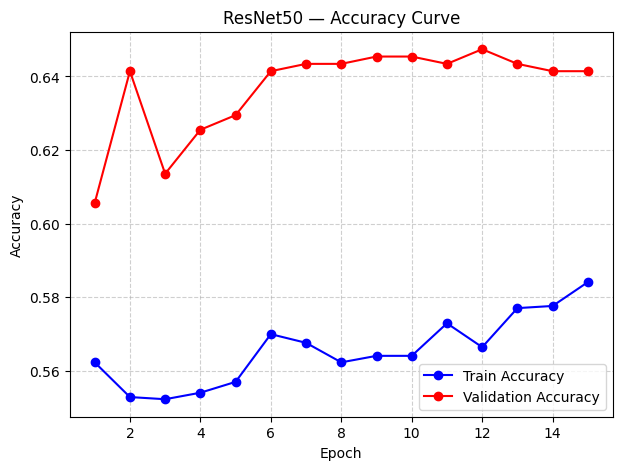

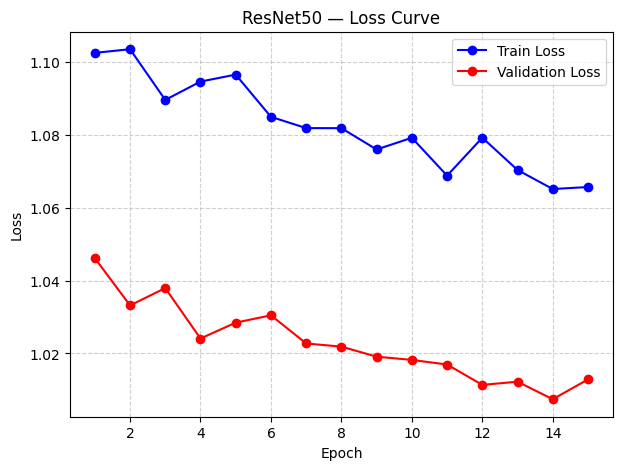

In [21]:
import matplotlib.pyplot as plt

def plot_history(hist, title="Training History"):
    if hist is None or not hasattr(hist, "history"):
        print(f"⚠️ Skipping plot for {title} — invalid or empty history object.")
        return

    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])

    if len(acc) == 0:
        print(f"⚠️ Skipping plot for {title} — no training data recorded.")
        return

    epochs = range(1, len(acc) + 1)

    # --- Accuracy Plot ---
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, acc, "b-o", label="Train Accuracy")
    if val_acc:
        plt.plot(epochs, val_acc, "r-o", label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} — Accuracy Curve")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # --- Loss Plot ---
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, loss, "b-o", label="Train Loss")
    if val_loss:
        plt.plot(epochs, val_loss, "r-o", label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} — Loss Curve")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# ✅ Call for all models
plot_history(hist_custom, "Custom CNN")
plot_history(hist_eff, "EfficientNetB0")
plot_history(hist_res, "ResNet50")



## 7. Model Evaluation
- Accuracy, Precision, Recall, F1
- Confusion Matrix



📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.94      0.93        80
  meningioma       0.80      0.38      0.52        63
    no_tumor       0.78      0.94      0.85        49
   pituitary       0.72      1.00      0.84        54

    accuracy                           0.81       246
   macro avg       0.80      0.81      0.78       246
weighted avg       0.82      0.81      0.79       246



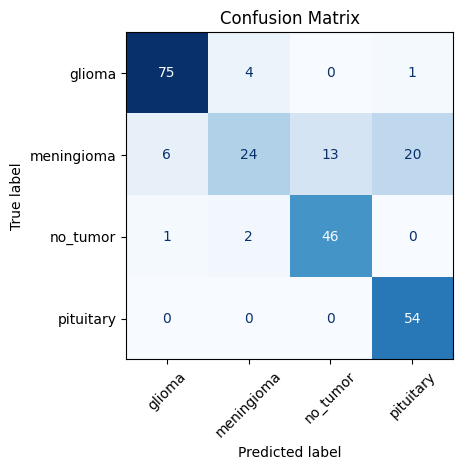


📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


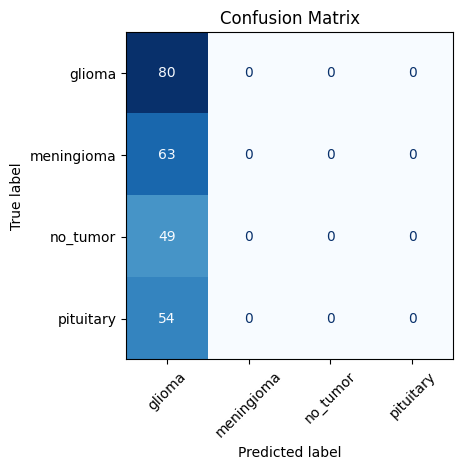


📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.60      0.80      0.68        80
  meningioma       0.62      0.24      0.34        63
    no_tumor       0.57      0.53      0.55        49
   pituitary       0.64      0.81      0.72        54

    accuracy                           0.61       246
   macro avg       0.61      0.60      0.57       246
weighted avg       0.61      0.61      0.58       246



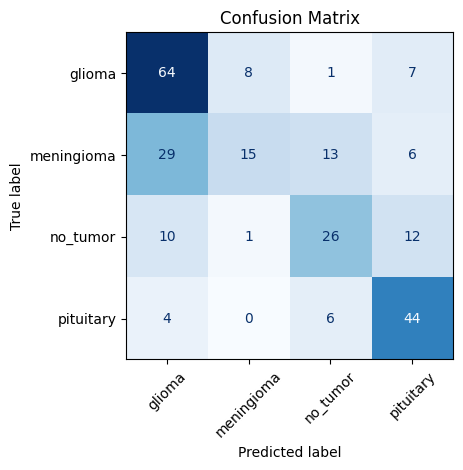


📈 Model Comparison Summary:
Custom CNN      | Acc: 0.809 | Prec: 0.816 | Recall: 0.809 | F1: 0.787
EfficientNetB0  | Acc: 0.325 | Prec: 0.106 | Recall: 0.325 | F1: 0.160
ResNet50        | Acc: 0.606 | Prec: 0.607 | Recall: 0.606 | F1: 0.577


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
)
import tensorflow as tf

def evaluate_model(model, ds, class_names):
    # --- Ensure model is compiled before evaluation ---
    if not hasattr(model, "optimizer") or model.optimizer is None:
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

    # --- Collect predictions ---
    y_true, y_pred = [], []
    for x, y in ds:
        preds = model.predict(x, verbose=0)
        y_true.extend(np.argmax(y.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # --- Compute metrics ---
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    # --- Classification report ---
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- Confusion matrix ---
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45, colorbar=False)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --- Return structured results ---
    return {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1}

# ✅ Choose the right evaluation split
eval_split = test_ds if test_ds is not None else val_ds

# ✅ Load models safely (modern format)
best_custom = tf.keras.models.load_model(path_custom, compile=False)
best_eff    = tf.keras.models.load_model(path_eff, compile=False)
best_res    = tf.keras.models.load_model(path_res, compile=False)

# ✅ Evaluate each model
metrics_custom = evaluate_model(best_custom, eval_split, CLASS_NAMES)
metrics_eff    = evaluate_model(best_eff,    eval_split, CLASS_NAMES)
metrics_res    = evaluate_model(best_res,    eval_split, CLASS_NAMES)

# ✅ Display summary
print("\n📈 Model Comparison Summary:")
for name, m in zip(["Custom CNN", "EfficientNetB0", "ResNet50"],
                   [metrics_custom, metrics_eff, metrics_res]):
    print(f"{name:15s} | Acc: {m['accuracy']:.3f} | Prec: {m['precision']:.3f} | "
          f"Recall: {m['recall']:.3f} | F1: {m['f1']:.3f}")



## 8. Model Comparison
Compare Custom CNN vs EfficientNetB0 vs ResNet50.


In [24]:
import pandas as pd
from IPython.display import display

def to_row(name, m):
    """Convert metrics dict into a clean single-row DataFrame entry."""
    return {"Model": name, **{k.capitalize(): round(float(v), 4) for k, v in m.items()}}

# --- Build the comparison table ---
comparison = pd.DataFrame([
    to_row("Custom CNN", metrics_custom),
    to_row("EfficientNetB0", metrics_eff),
    to_row("ResNet50", metrics_res),
])

# --- Sort & reset index ---
comparison = comparison.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# --- Detect numeric columns safely ---
numeric_cols = comparison.select_dtypes(include=["float", "int"]).columns

# --- Display with styling ---
print("📊 Model Performance Comparison:")
styled = (
    comparison.style
    .background_gradient(subset=["Accuracy", "F1"], cmap="Blues")
    .format("{:.4f}", subset=numeric_cols)   # ✅ Format only numeric columns
    .set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center'),
                                      ('background-color', '#f0f0f0'),
                                      ('font-weight', 'bold')]}]
    )
    .hide(axis="index")
)
display(styled)


📊 Model Performance Comparison:


Model,Accuracy,Precision,Recall,F1
Custom CNN,0.8089,0.8157,0.8089,0.7867
ResNet50,0.6057,0.6071,0.6057,0.5770
EfficientNetB0,0.3252,0.1058,0.3252,0.1596



### (Optional) Fine-tuning the Top Layers
Unfreeze top layers of the pretrained backbone and train with a lower learning rate to squeeze extra accuracy.


In [25]:
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks

def fine_tune(
    model,
    base_name="efficientnetb0",
    train_ds=None,
    val_ds=None,
    unfreeze_at=200,
    epochs=10
):
    """
    Fine-tunes a pretrained model by unfreezing top convolutional layers.
    Works with EfficientNet, ResNet, MobileNet, etc.
    """

    # --- Detect base model (usually the second layer in transfer models) ---
    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and "efficientnet" in layer.name.lower():
            base_model = layer
            break
        if isinstance(layer, tf.keras.Model) and "resnet" in layer.name.lower():
            base_model = layer
            break
        if isinstance(layer, tf.keras.Model) and "mobilenet" in layer.name.lower():
            base_model = layer
            break

    if base_model is None:
        print("⚠️ Could not detect pretrained base model — skipping fine-tuning.")
        return model

    print(f"🔍 Found base model: {base_model.name}")
    print(f"🔓 Unfreezing the top {unfreeze_at} layers...")

    # --- Unfreeze last N layers for fine-tuning ---
    for layer in base_model.layers[-unfreeze_at:]:
        layer.trainable = True

    # --- Recompile with lower learning rate ---
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # --- Callbacks ---
    cbs = [
        callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=2, factor=0.5, verbose=1)
    ]

    print(f"🚀 Fine-tuning {base_name.upper()} for {epochs} epochs with lr=1e-5...")
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs)

    print("✅ Fine-tuning complete.")
    return model



## 9. Export Artifacts
Save class names and best models for deployment (e.g., Streamlit app).


In [26]:
import os
import json
import shutil
from datetime import datetime

# --- Define export directory ---
EXPORT_DIR = "/content/exports" if IN_COLAB else "./exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

# --- Save class labels ---
labels_path = os.path.join(EXPORT_DIR, "class_names.json")
with open(labels_path, "w") as f:
    json.dump(CLASS_NAMES, f, indent=4, ensure_ascii=False)
print(f"✅ Saved class labels → {labels_path}")

# --- Copy model files (only if they exist) ---
exported_models = []
for p in [path_custom, path_eff, path_res]:
    if p and os.path.exists(p):
        dest = os.path.join(EXPORT_DIR, os.path.basename(p))
        shutil.copy2(p, dest)  # copy2 preserves metadata
        exported_models.append(dest)
    else:
        print(f"⚠️ Skipped missing model file: {p}")

# --- Add timestamped summary ---
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"\n🗂 Export completed at {timestamp}")
print("📦 Files exported successfully:")
for f in exported_models + [labels_path]:
    print("  -", f)

# --- Optional: Colab download support ---
if IN_COLAB:
    try:
        from google.colab import files
        print("\n⬇️ Preparing files for download (Colab environment detected)...")
        for f in exported_models + [labels_path]:
            files.download(f)
    except Exception as e:
        print(f"⚠️ Download skipped — {e}")


✅ Saved class labels → /content/exports/class_names.json

🗂 Export completed at 2025-11-11 16:06:11
📦 Files exported successfully:
  - /content/exports/best_custom_cnn_20251111_152616.keras
  - /content/exports/best_efficientnetb0_20251111_153501.keras
  - /content/exports/best_resnet50_20251111_153916.keras
  - /content/exports/class_names.json

⬇️ Preparing files for download (Colab environment detected)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## 10. Deploy with Streamlit (Local)
1. Put the best `.h5` model into `models/` in your local repo
2. Put `class_names.json` into the project root or `app/` and load it in the app
3. Run:
```bash
pip install -r requirements.txt
streamlit run app/app.py
```
Update `app.py` to point to your saved model and label JSON.
